In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import torch, random, subprocess, tempfile, json, cv2, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
from tqdm import tqdm
from pathlib import Path
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from IPython.display import display
from IPython.display import HTML

# パスを通す
import sys
sys.path.append('../')

import util

import warnings
warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter('ignore', UserWarning)


def draw_text(image, text, position, font=cv2.FONT_HERSHEY_SIMPLEX, font_scale=1, font_thickness=2, color=(255, 255, 255)):
    """
    画像に改行を含む文章を表示する関数
    """
    y0, dy = position[1], 50  # 初期y座標と行間距離
    for line in text.split('\n'):
        y = y0 + dy
        cv2.putText(image, line, (position[0], y), font, font_scale, color, font_thickness, lineType=cv2.LINE_AA)
        y0 = y  # 次の行の座標を更新

    return image

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
work_dir = list(Path('../__output__/08_MMPose/HRNet/04_GTt+GENX_num_auto_loop5/').glob("*"))
# work_dir = list(Path('../__output__/08_MMPose/ViTPose/04_GTt+GENX_num_auto_loop5/').glob("*"))
# work_dir = list(Path('../__output__/08_MMPose/ViTPose_small/04_GTt+GENX_num_auto_loop5/').glob("*"))
# work_dir = list(Path('../__output__/08_MMPose/HRNet/04_GTt+GENX_num_auto_loop1/').glob("*"))
# work_dir = list(Path('../__output__/08_MMPose/HRNet/04_GTt+GENX_num_auto_loop6/').glob("*"))
# work_dir = list(Path('../__output__/08_MMPose/HRNet/test_parallel_loop/').glob("*"))
work_dir.sort()

work_dir = work_dir[:]

work_name = work_dir[0].parent.parent.stem
print("-----------------")
print(work_name)
print("-----------------")
    
train_work_dir_paths = [{"name":p.stem, "path":p} for p in work_dir]
print(len(train_work_dir_paths))
for i, work_dir in enumerate(train_work_dir_paths):
    print(f"[{i}]work_dir: {work_dir['name']}")
    if not work_dir["path"].exists():
        raise Exception(f"指定されたパスが存在しません。{work_dir['path']}")

-----------------
HRNet
-----------------
5
[0]work_dir: 20240122-00522812__td-hm-ViTPose-small_04_2_GTt50+GEN250_auto_select_n300
[1]work_dir: 20240122-00522817__td-hm-ViTPose-small_04_2_GTt50+GEN250_auto_select_n300
[2]work_dir: 20240122-00522831__td-hm-ViTPose-small_04_2_GTt50+GEN250_auto_select_n300
[3]work_dir: 20240122-00522855__td-hm-ViTPose-small_04_2_GTt50+GEN250_auto_select_n300
[4]work_dir: 20240122-00522867__td-hm-ViTPose-small_04_2_GTt50+GEN250_auto_select_n300


### 学習過程（TensorBoard）を可視化
TODO: グループごとで線を表示するようにしたい

100%|██████████| 5/5 [00:15<00:00,  3.19s/it]


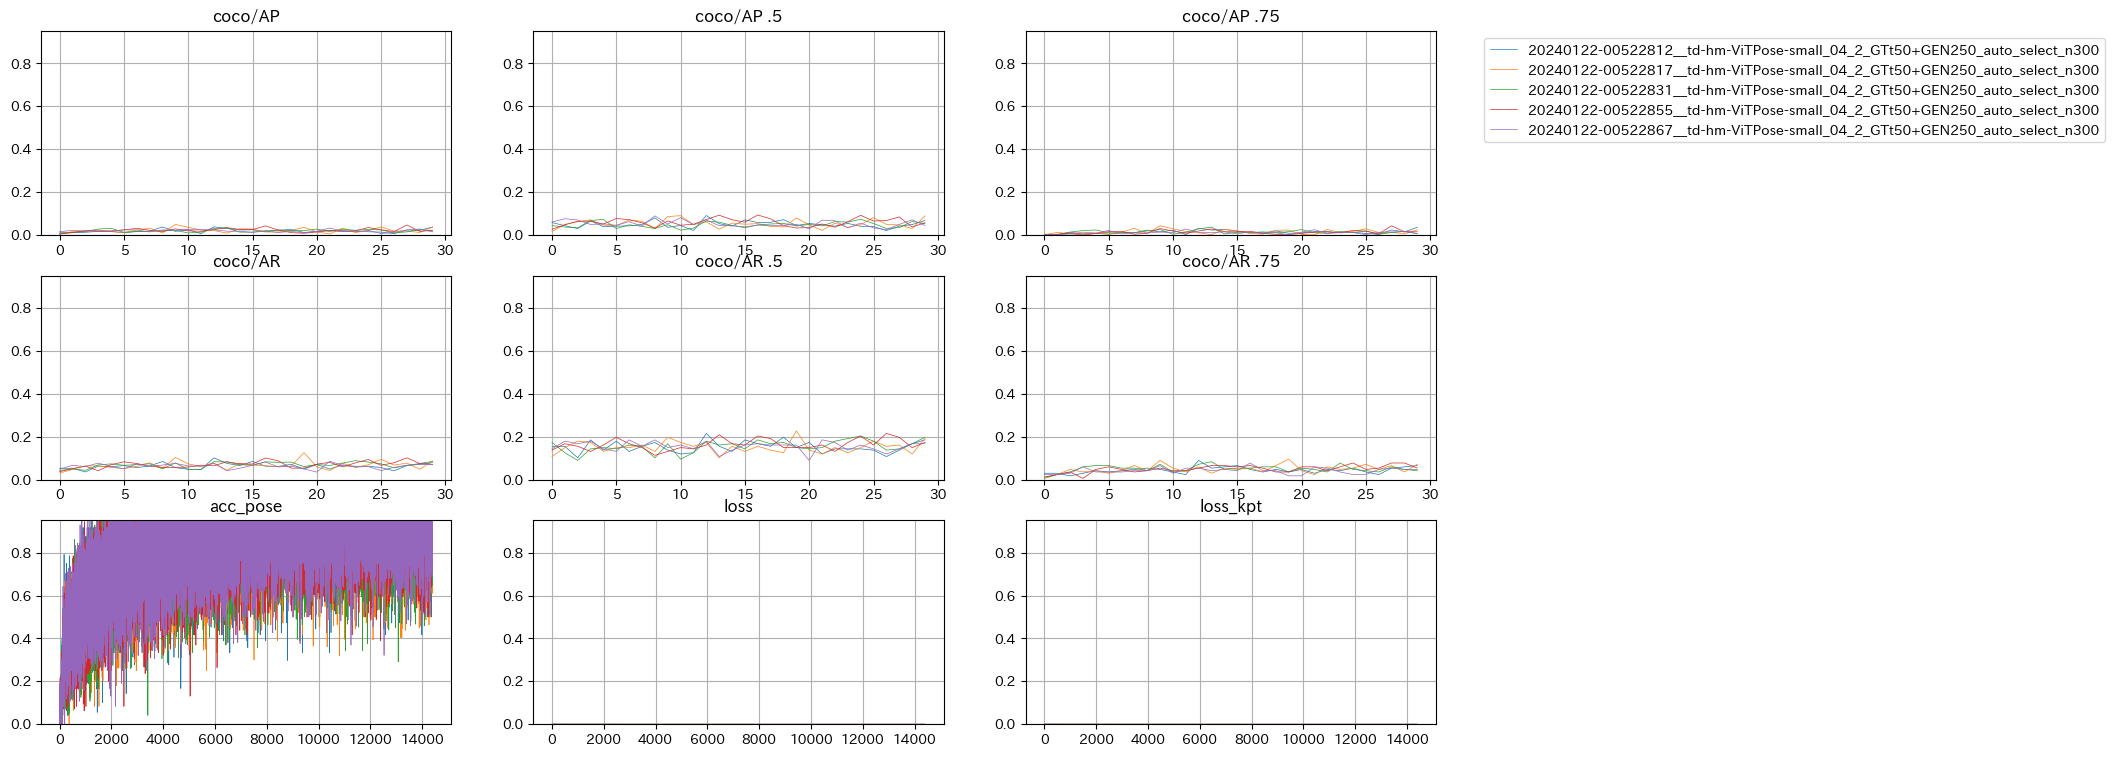

<Figure size 640x480 with 0 Axes>

In [3]:
## MMDetectionの学習結果を確認
Pose_model_trian_result_df_dict = {}

for train_work_dir in tqdm(train_work_dir_paths):    
    label_name = "_".join(Path(train_work_dir["path"]).stem.split("_")[5:])
    if train_work_dir["name"] is not None:
        label_name = train_work_dir["name"]

    pattern = re.compile(r'^\d+_\d+$')
    matched_folders = [f for f in train_work_dir["path"].glob('*_*') if f.is_dir() and pattern.match(f.name)]
    log_file_dir = matched_folders[0]
    
    Pose_model_trian_result_df_dict[label_name] = pd.DataFrame.from_dict(util.get_tensorboard_scalars(log_file_dir), orient='index').T
    

# 学習結果をグラフ化
show_columns = ['coco/AP', 'coco/AP .5', 'coco/AP .75', 'coco/AR', 'coco/AR .5', 'coco/AR .75', 'acc_pose', 'loss', 'loss_kpt']

fig_rows = 3
fig_cols = int(len(show_columns)/fig_rows)
fig, ax = plt.subplots(fig_rows, fig_cols, figsize=(6*fig_cols, 3*fig_rows))

for i, column in enumerate(show_columns):
    row, col = i//fig_cols, i%fig_cols
    for key in Pose_model_trian_result_df_dict:
        Pose_model_trian_result_df_dict[key][column].plot(ax=ax[row][col], label=key, ylim=[0, 0.95], linewidth=0.5)
    
    ax[row][col].set_title(column)
    ax[row][col].grid() 
    
ax[0][fig_cols-1].legend(loc='upper left', bbox_to_anchor=(1.10, 1.0,))
plt.show()
plt.cla(); plt.clf()


## 評価用データセットで定量評価  

In [4]:
# 評価データセットのみ
results = {}

for train_work_dir in tqdm(train_work_dir_paths):
    
    validation_dir = train_work_dir["path"]/"validation"/"test"
    if not validation_dir.exists():
        validation_dir.mkdir(parents=True)
    else:
        tmp_list = []
        for name in validation_dir.parent.glob("*test*"):
            matches = re.findall(r'\d+$', str(name))
            if matches:
                tmp_list.append(int(matches[-1]))
        
        max_num = 0
        if len(tmp_list) != 0:
            max_num = max(tmp_list)
            temp_validation_dir = Path(str(validation_dir) + str(max_num))
        else:
            temp_validation_dir = validation_dir
        
        evaluate_json_path = list(Path(temp_validation_dir).glob("**/*.json"))
        if len(evaluate_json_path) != 0:
            with open(evaluate_json_path[0]) as f:
                result_json = json.load(f)
            label_name = "_".join(Path(train_work_dir["path"]).stem.split("_")[5:])
            if train_work_dir["name"] is not None:
                label_name = train_work_dir["name"]
            results[label_name] = result_json
            continue
        else:
            validation_dir = Path(str(validation_dir) + str(max_num+1))
            validation_dir.mkdir(parents=True)
    
    
    model_path, config_path = util.get_train_model_and_config(train_work_dir["path"], model_type="best")

    cmd = f'python 03_evaluate_MMPose.py {config_path} {model_path} --work-dir {validation_dir}'
    process = (subprocess.Popen(cmd, stdout=subprocess.PIPE, shell=True).communicate()[0]).decode('utf-8')
    with open(list(Path(validation_dir).glob("**/*.json"))[0]) as f:
        result_json = json.load(f)
    label_name = "_".join(Path(train_work_dir["path"]).stem.split("_")[5:])
    if train_work_dir["name"] is not None:
        label_name = train_work_dir["name"]

    results[label_name] = result_json


det_results_dict = {
                        "train_work_dir":[key for key in results],
                        **{col_name:[results[key][col_name] for key in results] for col_name in results[list(results.keys())[0]]},
                    }
det_evaluete_df = pd.DataFrame(det_results_dict)
print(det_evaluete_df.head(1))
# print(det_evaluete_df)

100%|██████████| 5/5 [01:24<00:00, 16.95s/it]

                                      train_work_dir   coco/AP  coco/AP .5  \
0  20240122-00522812__td-hm-ViTPose-small_04_2_GT...  0.033164    0.075925   

   coco/AP .75  coco/AP (M)  coco/AP (L)   coco/AR  coco/AR .5  coco/AR .75  \
0     0.027664     0.048263     0.030116  0.075694    0.173611     0.055556   

   coco/AR (M)  coco/AR (L)  data_time      time  
0     0.088372     0.070297   0.005508  0.082005  


In [5]:
# 各行の 'train_work_dir' から後半部分を抽出
text = "-w48_"
# text = "simple_"
# text = "-small_"
det_evaluete_df["suffix"] = det_evaluete_df["train_work_dir"].apply(lambda x: x.split(text)[-1])

# columns = ['coco/AP', 'coco/AP .5', 'coco/AP .75', 'coco/AR', 'coco/AR .5', 'coco/AR .75']
columns = ['coco/AP', 'coco/AP .5', 'coco/AR', 'coco/AR .5']

# # 各グループの平均値と標準偏差を計算
result = det_evaluete_df.groupby("suffix")[columns].agg(["mean", "std", "count"])

# 'mean±std' の形式の文字列を作成する関数
def format_mean_std(row, metric):
    mean = row[(metric, 'mean')]
    std = row[(metric, 'std')]
    return f"{mean:.4f} ± {std:.4f}" if not pd.isna(std) else f"{mean:.4f} ± NA"

# 各メトリックに対して 'mean±std' 形式の文字列を作成
for metric in columns:
    result[(metric, 'mean±std')] = result.apply(lambda row: format_mean_std(row, metric), axis=1)

# HTML(result[[metric for metric in columns for metric in [(metric, 'mean±std')]]].round(3).to_html())

view_result = pd.concat([result[[metric for metric in columns for metric in [(metric, 'mean±std')]]], result[(columns[0], 'count')]], axis=1)
HTML(view_result.round(3).to_html())



,coco/AP,coco/AP .5,coco/AR,coco/AR .5,coco/AP
,mean±std,mean±std,mean±std,mean±std,count
suffix,,,,,
04_2_GTt50+GEN250_auto_select_n300,0.0303 ± 0.0084,0.0723 ± 0.0215,0.0840 ± 0.0137,0.1819 ± 0.0352,5


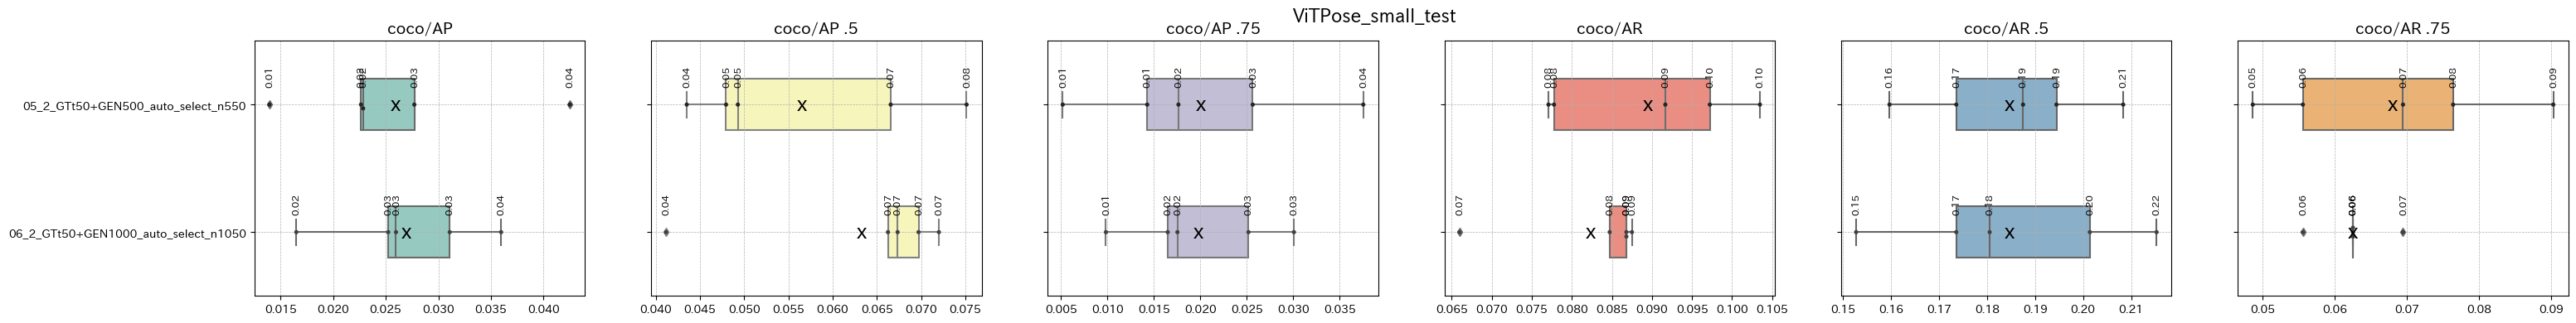

In [6]:
# columns = ['coco/AP', 'coco/AP .5', 'coco/AP .75', 'coco/AR', 'coco/AR .5', 'coco/AR .75']
columns = ['coco/AP', 'coco/AP .5', 'coco/AR', 'coco/AR .5']
# columns = ['coco/AP .5']
tmp = list(det_evaluete_df.groupby("suffix")[columns])

result_dfs = []
for col in columns:
    result_dicts = {label[0] : label[1][col].to_list() for label in tmp}

    # 各キーのリストの最大長を取得
    max_length = max(len(lst) for lst in result_dicts.values())

    # 各リストを最大長に合わせて拡張
    for key, lst in result_dicts.items():
        length_difference = max_length - len(lst)
        if length_difference > 0:
            # 足りない部分をNaNで埋める
            result_dicts[key] = lst + [np.nan] * length_difference

    temp_df = pd.DataFrame(result_dicts)
    result_dfs.append(temp_df)

_ = util.plot_multiaxis_boxplots_H(result_dfs, graph_main_title=f"{work_name}_test", graph_sub_titles=columns, base_figsize=(6,4), x_label_first_only=True, value_label_offset=-0.2)
# util.plot_multiaxis_boxplots_H(result_dfs, graph_main_title=f"", graph_sub_titles=[f"{work_name}"], base_figsize=(6,4), x_label_first_only=True, value_label_offset=-0.2, base_swarm_size=0, value_plot=False, box_width=0.8)

### 論文用プロット

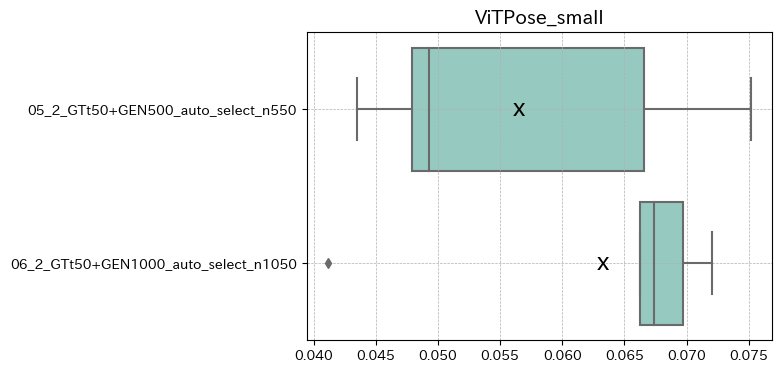

In [12]:
columns = ['coco/AP', 'coco/AP .5', 'coco/AP .75', 'coco/AR', 'coco/AR .5', 'coco/AR .75']
columns = ['coco/AP', 'coco/AP .5', 'coco/AR', 'coco/AR .5']
columns = ['coco/AP .5']
columns = ['coco/AP', 'coco/AP .5']
tmp = list(det_evaluete_df.groupby("suffix")[columns])

result_dfs = []
for col in columns:
    result_dicts = {label[0] : label[1][col].to_list() for label in tmp}

    # 各キーのリストの最大長を取得
    max_length = max(len(lst) for lst in result_dicts.values())

    # 各リストを最大長に合わせて拡張
    for key, lst in result_dicts.items():
        length_difference = max_length - len(lst)
        if length_difference > 0:
            # 足りない部分をNaNで埋める
            result_dicts[key] = lst + [np.nan] * length_difference

    temp_df = pd.DataFrame(result_dicts)
    
    result_dfs.append(temp_df)


name = ["mAP", "mAP50"]
fig = util.plot_multiaxis_boxplots_H(result_dfs, graph_main_title=f"{work_name}", graph_sub_titles=name, base_figsize=(6,4), x_label_first_only=True, value_label_offset=-0.2, base_swarm_size=0, value_plot=False, box_width=0.8)
_ = util.save_plot_fig(fig, output_dir="../__output__/plots/08_MMPose_evaluate/", output_image_name=f"evaluate_{work_name}_target-{len(train_work_dir_paths)}.png")